## ML Part- Data Project
#### Submitted By:
- **Niv Harel**: 208665869
- **Eytan Muzafi**: 209160308

#### Github: [https://github.com/nivrl/Data_Course_3rd_year.git]

In [1]:
# Please run this cell:
# !pip install geopy

#### Imports

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import re
import requests
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from geopy.geocoders import Nominatim

#### Creating dictionaries for later use 

In [3]:
CITIES_DICT = {}


COLOR_CATEGORIES = {
    'common': ['כסוף','שחור', 'אפור', 'לבן'],
    'less common': ['זהב', 'שמפניה', 'אדום', 'כחול', 'בורדו', 'בז׳']
}

HEBREW_TO_ENGLISH_ENGINE_TYPE = {
    'בנזין': 'Petrol',
    'גז': 'Gas',
    'דיזל': 'Diesel',
    'היבריד': 'Hybrid',
    'היברידי': 'Hybrid',
    'חשמלי': 'Electric',
    'טורבו דיזל': 'Turbo Diesel'
}

HEBREW_TO_ENGLISH_GEAR = {
    'אוטומטית': 'Automatic',
    'טיפטרוניק': 'Tiptronic',
    'ידנית': 'Manual',
    'רובוטית': 'Robotic',
    'אוטומט': 'Automatic',
    'None': 'Undefined',
    'לא מוגדר': 'Undefined'
}

#### Reading and understanding the dataset

In [40]:
df= pd.read_csv("original_dataset_second_part.csv")
df.head()

,manufactor,Year,model,Hand,Gear,capacity_Engine,Engine_type,Prev_ownership,Curr_ownership,Area,City,Price,Pic_num,Cre_date,Repub_date,Description,Color,Km,Test,Supply_score
0,יונדאי,2015,i35,2,אוטומטית,1600,בנזין,פרטית,פרטית,רעננה - כפר סבא,רעננה,51000.0,2.0,11/07/2023,11/07/2023,['רכב שמור בקנאות\nמוכרת עקב קבלת רכב חברה'],כחול כהה מטאלי,144000,NaN,NaN
1,ניסאן,2018,ניסאן מיקרה,1,אוטומטית,1200,בנזין,פרטית,פרטית,מושבים בשרון,אבן יהודה,49000.0,0.0,06/04/2022,22/05/2022,['שמורה כל התוספות'],כחול בהיר,69000,NaN,NaN
2,סוזוקי,2010,סוזוקי סוויפט,1,אוטומטית,1450,בנזין,NaN,NaN,רמת,רמת,22500.0,1.0,29/10/2022,29/10/2022,['רכב במצב מתוחזק ברמה גבוהה טסט עד אפריל 2023'],None,145000,NaN,NaN
3,טויוטה,2016,אוריס,1,טיפטרוניק,1600,בנזין,פרטית,פרטית,נס ציונה - רחובות,רחובות,63000.0,5.0,16/05/2024,16/05/2024,['אוטו במצב חדש!! שמור בקנאות!! נהג יחיד מטופל...,אפור מטאלי,27300,NaN,NaN
4,קיה,2012,פיקנטו,1,אוטומטית,1248,בנזין,NaN,NaN,"ראשל""צ והסביבה",ראשון לציון,37000.0,1.0,13/06/2022,13/06/2022,['שמור'],NaN,70000,NaN,4.0


In [5]:
df.dtypes

manufactor          object
Year                 int64
model               object
Hand                 int64
Gear                object
capacity_Engine     object
Engine_type         object
Prev_ownership      object
Curr_ownership      object
Area                object
City                object
Price              float64
Pic_num            float64
Cre_date            object
Repub_date          object
Description         object
Color               object
Km                  object
Test                object
Supply_score       float64
dtype: object

In [42]:
df.isnull().sum()

manufactor            0
Year                  0
model                 0
Hand                  0
Gear                  1
capacity_Engine      26
Engine_type           5
Prev_ownership      726
Curr_ownership      726
Area                139
City                  0
Price                 0
Pic_num              24
Cre_date              0
Repub_date            0
Description           0
Color               713
Km                   88
Test               1361
Supply_score       1061
dtype: int64

### Functions we use later on for feature engineering

#### 1. Convert city values to 7 main areas based on locations in israel.
we dicided to convert the city column into 7 main areas based on their locations in order to avoid overfitting.
We will use only this column afterwards and not the area column (because city has 0 nulls).

IMPORTANT TO MENTION:
* We do the this casting according to latitude and longitude on the map.
* We decided to use this function instead of just taking the top 5-10 most popular cities because: *It improves the RMSE in the perdiction model. *there are too many different styles of writing for the same city, and this function converts most of the data correctly. *We treat all cities uniformly instead of just taking the most popular ones and labeling all others as 'Others'.


Example: 'Tzofim' village

In [6]:
geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('צופים') 
print(location)
latitude = location.latitude
longitude = location.longitude
print(f"lat:{latitude}, long:{longitude}")

צופים, שטח C, יהודה ושומרון, الأراضي الفلسطينية
lat:32.1981952, long:35.0096527


In [7]:
## convert city to 7 main poplular areas --> used in convert_values_to_categorial func 
def city_to_location(city_name):
    if city_name in CITIES_DICT:
        return CITIES_DICT[city_name]
    geolocator = Nominatim(user_agent="my_geocoder")
    try:
        location = geolocator.geocode(city_name) 
        latitude = location.latitude
        longitude = location.longitude
        
        if (29.5 <= latitude <= 31.5) and (34.3 <= longitude <= 35.5):
            CITIES_DICT[city_name] = "South"
            return "South"
        elif (31.5 <= latitude <= 32.05) and (34.3 <= longitude <= 35.5):
            CITIES_DICT[city_name] = "South_Central"
            return "South_Central"
        elif (32.05 <= latitude <= 32.3) and (34.3 <= longitude <= 35.5):
            CITIES_DICT[city_name] = "Mid_Central"
            return "Mid_Central"
        elif (32.5 <= latitude <= 33.1) and (34.3 <= longitude <= 35.5):
            CITIES_DICT[city_name] = "Light_North"
            return "Light_North"
        elif (32.3 <= latitude <= 32.55) and (34.3 <= longitude <= 35.5):
            CITIES_DICT[city_name] = "North_Central"
            return "North_Central"
        elif (33.1 <= latitude <= 35.0) and (34.3 <= longitude <= 35.7):
            CITIES_DICT[city_name] = "North"
            return "North"
        else:
            CITIES_DICT[city_name] = "Unknown"
            return "Unknown"              
    except Exception as e:
        return 'Unknown'

#### 2- Reduce color, manufactor and model catgories.

For color: Based on the RMSE from the model, we decided to split the colors into common and less common categories based on our understanding, rather than the frequency of each color type in the data, because our split resulted in a better RMSE. If there will be a color that is not in the dictionary we built- this color will get the 'unknown' value.

In [8]:
## reduce color values --> used in convert_values_to_categorial func
def reduce_multi_values(reduce_type, name):
        for color_type in COLOR_CATEGORIES:
            if name in COLOR_CATEGORIES[color_type]:
                return color_type
        return "unknown"          

The next function processes each column as follows:

* City: Executes the location function above for each city.
* Color: Executes the function above to reduce the number of defferent colors.
* Manufacturer/Model: Counts how many times each value appears and then converts it to a percentage. We retain only the values that occur more than 2%, and the others will be set to 'Other'.

The purpose is to avoid overfitting!


In [9]:
## generate the categorial values by the functions above --> used in orgnazing_data func
def convert_values_to_categorial(df,column_name):
    if column_name == 'City':
        df[column_name] = df[column_name].apply(lambda x: city_to_location(x))
    elif column_name == 'Color':
        df[column_name] = df[column_name].apply(lambda x: reduce_multi_values(column_name, x))
    else: # manufactor and model 
        temp_df = df[column_name].value_counts().reset_index()
        temp_df.columns = [column_name,'count']
        temp_df['percentege']=temp_df['count']/len(df[column_name].notnull()) # calc the percentege for the name
        list_common=temp_df[temp_df['percentege'] >= 0.02][column_name].to_list() # extract list of all the names that appear more then 2% in the data
        df[column_name] = df[column_name].apply(lambda x: x if x in list_common else 'Other')
    return df[column_name]

#### 3- Create a measure of demand
We aim to create a measure of demand for each manufacturer and year using the API we received in part 1 of the project.
[documantion](https://data.gov.il/dataset/degem-rechev-wltp/resource/5e87a7a1-2f6f-41c1-8aec-7216d52a6cf6)
1. extract_from_api: extract from api per manufactor
2. create_supply_score_for_manufactor: create the measure of demand with group by
3. create_supply_score: create the measure of demand for list of manufactors

In [10]:
def extract_from_api(manufactor):
    filters_dict='{"tozar":"'+manufactor+'"}'
    x = requests.get(f"https://data.gov.il/api/3/action/datastore_search?resource_id=5e87a7a1-2f6f-41c1-8aec-7216d52a6cf6&filters={filters_dict}")
    json=x.json()['result']['records']
    df=pd.DataFrame(json)
    return df

In [11]:
def create_supply_score_for_manufactor(manufactor: str):
    df_from_api=extract_from_api(manufactor)
    if len(df_from_api)==0:
        return pd.DataFrame()
    gb_df=df_from_api.groupby(['tozar','shnat_yitzur']).count().reset_index()
    return gb_df[['tozar','shnat_yitzur','_id']]

In [12]:
def create_supply_score_df(manufactors_list,response_df):
    for manufactor in manufactors_list: 
        cur_df=create_supply_score_for_manufactor(manufactor)
        response_df = pd.concat([response_df, cur_df])
    return response_df

In [13]:
## Merge the supply_score df that we built into the original df 
def apply_supply_score(supply_score_df, original_df):
    merged_df = original_df.merge(
    supply_score_df,
    left_on=['manufactor', 'Year'],
    right_on=['tozar', 'shnat_yitzur'],
    how='left')
    return merged_df

### Cleaning the data

Function to fill nulls with the most frequent value

In [14]:
## Fill nulls with the most used value based on a key and a target column --> used in orgnazing_data func
def fillna_with_mode(df, group_col, target_col):
    mode_values = df.groupby(group_col,observed=False)[target_col].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    return df[target_col].fillna(df[group_col].map(mode_values))

In [41]:
## Understanding what is the most frequent Gear value each year
df.groupby('Year')['Gear'].agg(lambda x: x.mode().iloc[0]).reset_index().sort_values(by='Year')

,Year,Gear
0,1983,ידנית
1,1988,אוטומטית
2,1990,אוטומטית
3,1995,ידנית
4,1998,אוטומטית
5,1999,אוטומטית
6,2000,אוטומטית
7,2002,אוטומטית
8,2003,אוטומטית
9,2004,אוטומטית


#### Main function to handle all the null values for each column

In [15]:
## Handle all the null values in the df --> used in orgnazing_data func
def handle_nulls(df, column_name):

## Based on the data and internet research- We assumed that from the the year 2000- Most of the cars are automatic
    if column_name == 'Gear':
        df['Gear'] = df['Gear'].apply(lambda x: np.nan if x == 'לא מוגדר' else x)
        df.loc[(df['Gear'].isnull()) & (df['Year'] >= 2000), 'Gear'] = 'אוטומט'
        df.loc[(df['Gear'].isnull()) & (df['Year'] <= 1999), 'Gear'] = 'ידנית'
    
## We fill null values, if exist, with the mean value of the column
    elif column_name == 'Year':
        mean_Year = int(df['Year'].mean())
        df['Year'] = df['Year'].fillna(mean_Year)

    elif column_name == 'Hand':
        mean_Hand = int(df['Hand'].mean())
        df['Hand'] = df['Hand'].fillna(mean_Hand)
        
## For capacity_Engine- we first find the maximum capacity_Engine for each manufactor and model and then fill the nulls based on it. If there are still nulls existing- we fill them by the total mean of the capacity_Engine
    elif column_name == 'capacity_Engine':
        max_capacity = df.groupby(['manufactor', 'model'], as_index=False, observed=False)['capacity_Engine'].max().rename(columns={'capacity_Engine': 'mean_capacity_engine'})
        temp_df = pd.merge(df, max_capacity, on=['manufactor', 'model'], how='left')
        df['capacity_Engine'] = temp_df['capacity_Engine'].fillna(temp_df['mean_capacity_engine'])
        df["capacity_Engine"] = pd.to_numeric(df['capacity_Engine'], errors='coerce')
        mean_capacity_Engine = df['capacity_Engine'].mean()
        df['capacity_Engine'] = df['capacity_Engine'].fillna(int(mean_capacity_Engine))

## We fill null values of Engine_type with the mean value of the column
    elif column_name == 'Engine_type':
        most_used_type_Engine = df['Engine_type'].mode()
        df['Engine_type'] = df['Engine_type'].fillna(most_used_type_Engine)

## For those columns we understood that the fillna that gives the best RMSE in the prediction model is the one that calls to the fillna_with_mode function and maps for every manufactor the most popular ownership it has
    elif 'ownership' in column_name: # for both curr and prev
        df[column_name] = df[column_name].str.replace('None','לא מוגדר')        
        df[column_name] = df[column_name].apply(lambda x: np.nan if x == 'לא מוגדר' else x)
        df[column_name] = fillna_with_mode(df, 'manufactor', column_name) 

## For each color, we filter out unnecessary words, create a mapping for each manufacturer to identify its most frequent color, and fill in null values based on this mapping
        df['Color'] = df['Color'].apply(lambda x: np.nan if x == 'None' else x)
        df['Color'] = df['Color'].str.split().str[0]        
        manufacturer_mode_color = df.groupby('manufactor',observed=False)['Color'].agg(lambda x: x.mode().iloc[0] if not x.empty else np.nan)
        manufacturer_to_color = manufacturer_mode_color.to_dict()
        df['Color'] = df.apply(lambda row: manufacturer_to_color.get(row['manufactor'], np.nan) if pd.isnull(row['Color']) else row['Color'], axis=1)

## It calculates estimated km for null values based on manufacturers' average km per year adjusted by car age in years
    elif column_name == 'Km':
        current_year = datetime.now().year
        mean_total_years_df = current_year - df.groupby('manufactor',observed=False)['Year'].mean().astype(int)
        mean_total_years_dict = mean_total_years_df.to_dict()
        df["Km"] = pd.to_numeric(df['Km'], errors='coerce')
        manufacturer_mean_km_df = df.groupby('manufactor',observed=False)['Km'].mean()
        manufacturer_mean_km_dict = manufacturer_mean_km_df.to_dict()
        mean_km_total_dict = {}
        for key in manufacturer_mean_km_dict:
            mean_km_total_dict[key] = manufacturer_mean_km_dict[key] / mean_total_years_dict[key]
        df['Km'] = df.apply(lambda row: mean_km_total_dict.get(row['manufactor'])*(current_year - row['Year']) if pd.isnull(row['Km']) else row['Km'], axis=1)
    
    return df[column_name]

### Organizing the data

The goal of this part is to execute all the functions mentioned above, drop or fix incorrect values, and attempt to standardize the format of values in each column

In the next 2 functions we remove redundant words and signs from the model and manufactor columns

In [16]:
##regex on model column values for uniformity --> used in orgnazing_data func
def clean_model_values(series):
    series = series.str.strip()
    series = series.str.replace(r'\(\d{4}\)', '', regex=True)
    series = series.str.strip()
    return series

In [17]:
##remove redundant words from model column for uniformity --> used in orgnazing_data func
def remove_manufacturer_from_model(row):
    manufacturer = row['manufactor']
    model = row['model']
    pattern = r'\b' + re.escape(manufacturer) + r'\b'
    cleaned_model = re.sub(pattern, '', model).strip()
    return cleaned_model

Function for executing all the functions above

In [18]:
def organizing_data(df):
    df['model'] = df['model'].str.replace('\r\n','')
    df['model'] = df['model'].str.upper()
    df['model'] = clean_model_values(df['model'])
    df['model'] = df.apply(remove_manufacturer_from_model, axis=1)
    
    df['manufactor'] = df['manufactor'].str.replace('Lexsus','לקסוס')
    df['manufactor'] = df['manufactor'].str.replace('וולוו','וולבו')
    df['manufactor'] = df['manufactor'].str.replace('ב.מ.וו','ב מ וו')
    df['manufactor'] = df['manufactor'].str.replace('מאזדה','מזדה')
    
    df["Year"] = handle_nulls(df, 'Year')

## Adding the rank here after handling the nulls for year and manufactor
    ss_df=create_supply_score_df(df['manufactor'].unique().tolist(),pd.DataFrame())
    merged_df_per_y_and_m=apply_supply_score(ss_df, df)
    df['rank_by_m_and_y'] = merged_df_per_y_and_m['_id']

    ss_df_per_m=ss_df.groupby('tozar',observed=False)['_id'].sum().reset_index()
    merged_df_by_m = df.merge(ss_df_per_m,left_on=['manufactor'],right_on=['tozar'],how='left')
    df['rank_by_m'] = merged_df_by_m['_id']
    
    df["Hand"] = handle_nulls(df, 'Hand')

    df['Km'] = df['Km'].str.replace(',','')
    df['Km'] = pd.to_numeric(df['Km'], errors='coerce').astype('Int64')
    df['Km'] = df['Km'].apply(lambda x: x*1000 if type(x) == int and x < 1000 else x) # For values that are less than 1000 km (does not make sense)
    df['Km'] = handle_nulls(df, 'Km')

    df['capacity_Engine'] = df['capacity_Engine'].str.replace(',','')
    df['capacity_Engine'] = pd.to_numeric(df['capacity_Engine'], errors='coerce').astype('Int64')
    df['capacity_Engine'] = handle_nulls(df, 'capacity_Engine')

    df['Color'] = handle_nulls(df, 'Color')
    df['Color'] = convert_values_to_categorial( df,'Color')
    df['Color'] = df['Color'].astype('category')
    
    df['Curr_ownership'] = handle_nulls(df, 'Curr_ownership')
    df['Prev_ownership'] = handle_nulls(df, 'Prev_ownership')
    df['Curr_ownership'] = df['Curr_ownership'].astype('category')
    df['Prev_ownership'] = df['Prev_ownership'].astype('category')

## For Repub_date- we calculate the number of days between today and each date.
    date_format = "%d/%m/%Y"
    df['Repub_date'] = df['Repub_date'].apply(lambda x: (datetime.today()-datetime.strptime(x, date_format)).days if ((isinstance(x,str)) & ('/' in x)) else np.nan)

## The HEBREW_TO_ENGLISH_ENGINE_TYPE and the HEBREW_TO_ENGLISH_GEAR are just for convert some of the hebrew words to english
    df['Gear'] = df['Gear'].str.replace('אוטומטית', 'אוטומט')
    df['Gear'] = handle_nulls(df, 'Gear')
    df['Gear'] = df['Gear'].map(HEBREW_TO_ENGLISH_GEAR)
    df['Gear'] = df['Gear'].astype('category')
    
    df['Engine_type'] = handle_nulls(df, 'Engine_type')
    df['Engine_type'] = df['Engine_type'].map(HEBREW_TO_ENGLISH_ENGINE_TYPE)
    df['Engine_type'] = df['Engine_type'].astype('category')

    df['City'] = convert_values_to_categorial( df,'City')
    df['City'] = df['City'].astype('category')

    df['manufactor'] = convert_values_to_categorial( df,'manufactor')
    df['manufactor'] = df['manufactor'].astype('category')
    
    df['model'] = convert_values_to_categorial( df,'model')
    df['model'] = df['model'].astype('category')

    df=df.drop(columns=['Area','Description','Cre_date','Test','Supply_score']) # We won't use them
    
    return df

### Normalizing the data and converting categorial features

In [19]:
## OneHot encoder on the categorial columns- color, city, Prev_ownership, model, manufactor, Engine_type, Gear, manufactor
def convert_categorial_by_encoder(X, categorical_cols ):
    ohe = OneHotEncoder(sparse=False,drop='first') 
    encoded_categorical = ohe.fit_transform(X[categorical_cols])
    encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=ohe.get_feature_names_out(categorical_cols))
    return encoded_categorical_df

In [20]:
def normlize_nomarical_features(X,numerical_cols):
    # Normalize numerical features
    scaler = StandardScaler()
    scaled_numerical = scaler.fit_transform(X[numerical_cols])
    scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_cols)
    return scaled_numerical_df

In [21]:
def normalize_and_encode (df_prepared):
    X = df_prepared.drop("Price", axis=1)  # Assuming "price" is the target variable
    y = df_prepared["Price"]
    numerical_cols = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
    categorical_cols = [col for col in X.columns if col not in numerical_cols]

    encoded_categorical_df=convert_categorial_by_encoder(X,categorical_cols)
    scaled_numerical_df=normlize_nomarical_features(X,numerical_cols)
    
    # Combine features
    X_processed = pd.concat([encoded_categorical_df, scaled_numerical_df], axis=1)
    
    # Concat with price and drop nulls- 87 rows (Because we got a better RMSE without fill in the nulls or incorrect values in Repub_date, Pic_number, rank)
    normal_df=pd.concat([X_processed, y], axis=1).dropna() 

    return normal_df


### Feature Correlation
In order to have a better understanding on the features and to try reducing the number of features, we search for correlation between features

In [22]:
temp_df=organizing_data(df.copy())
X = temp_df.drop("Price", axis=1)
numerical_cols = [col for col in X.columns if pd.api.types.is_numeric_dtype(X[col])]
categorical_cols = [col for col in X.columns if col not in numerical_cols]
new_cat_cols = convert_categorial_by_encoder(X, categorical_cols) 
temp_df=pd.concat([new_cat_cols, X[numerical_cols]], axis=1)

<ipython-input-18-f97ced62ebae>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['manufactor'] = df['manufactor'].str.replace('ב.מ.וו','ב מ וו')
/Users/nivharel/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
numerical_cols = [col for col in temp_df.columns if pd.api.types.is_numeric_dtype(temp_df[col])]

# Calculate correlation matrix
correlation_matrix = temp_df[numerical_cols].corr()

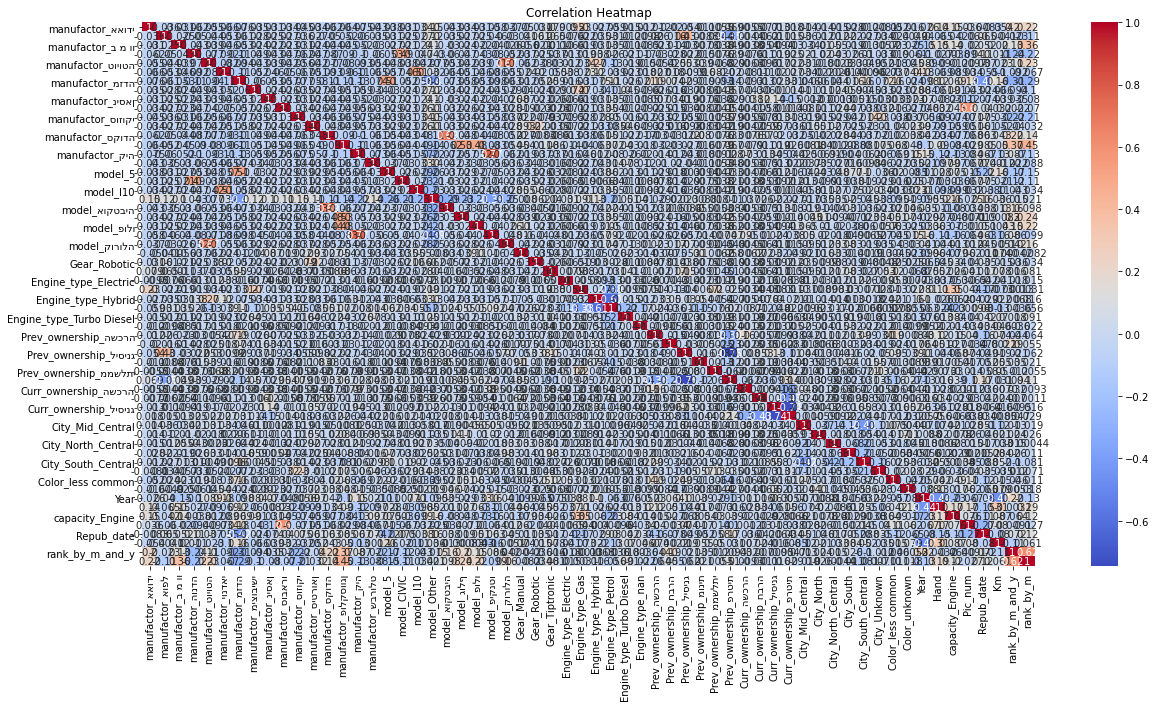

In [24]:
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  # Adjust colormap as desired
plt.title("Correlation Heatmap")
plt.show()

In [25]:
for index, row in correlation_matrix.iterrows():
  # Access row values using the Series object 'row'
  for col, _ in correlation_matrix.items():  # Iterate over column names, unused variable
    # Access the correlation coefficient for the current column
    correlation_value = row[col]
    if correlation_value >= 0.6 and correlation_value!=1.0:
        print(f"Row index: {index}")
        print(f"\tColumn '{col}': {correlation_value}")

Row index: manufactor_טויוטה
	Column 'model_קורולה': 0.6725470895252357
Row index: manufactor_סובארו
	Column 'Pic_num': 0.6021523846836531
Row index: manufactor_סקודה
	Column 'model_אוקטביה': 0.6922186552431734
Row index: manufactor_קיה
	Column 'model_פיקנטו': 0.7711356826558768
Row index: model_אוקטביה
	Column 'manufactor_סקודה': 0.6922186552431734
Row index: model_פיקנטו
	Column 'manufactor_קיה': 0.7711356826558768
Row index: model_קורולה
	Column 'manufactor_טויוטה': 0.6725470895252357
Row index: Pic_num
	Column 'manufactor_סובארו': 0.6021523846836531
Row index: rank_by_m_and_y
	Column 'rank_by_m': 0.6221040669450294
Row index: rank_by_m
	Column 'rank_by_m_and_y': 0.6221040669450294


We observed the columns with the highest correlations. However, when we attempted to remove them from the data and fit the model without them, we noticed an increase in the MSE to 220M. Due to these findings, we decided not to remove any features from the data based on the correlation test.

### Main executor- prepare_data

In [26]:
def prepare_data(df):
    df = organizing_data(df)
    df = normalize_and_encode(df)
    return df

In [27]:
df_prepared = prepare_data(df)
df_prepared.head(20)

<ipython-input-18-f97ced62ebae>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['manufactor'] = df['manufactor'].str.replace('ב.מ.וו','ב מ וו')
/Users/nivharel/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,manufactor_אאודי,manufactor_אופל,manufactor_ב מ וו,manufactor_הונדה,manufactor_טויוטה,manufactor_יונדאי,manufactor_מזדה,manufactor_מיצובישי,manufactor_ניסאן,manufactor_סובארו,...,Color_unknown,Year,Hand,capacity_Engine,Pic_num,Repub_date,Km,rank_by_m_and_y,rank_by_m,Price
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.171467,-0.284287,-0.078845,-0.239191,-0.848926,0.135699,-0.194423,-0.213267,51000.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.958016,-1.098084,-0.568385,-0.810926,0.881906,-0.790545,-0.225175,-0.544456,49000.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.139446,-1.098084,-0.262422,-0.525058,0.214597,0.148049,-1.106733,-0.988674,22500.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.433650,-1.098084,-0.078845,0.618411,-2.141837,-1.305537,0.246356,0.891354,63000.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.615081,-1.098084,-0.509640,-0.525058,0.790151,-0.778195,-0.737709,-0.361834,37000.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.171467,0.529511,-0.323615,-0.525058,0.748444,-0.160699,1.804458,1.037453,60000.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,-1.401629,0.529511,0.900237,3.762951,-0.944852,-0.098949,0.256607,-0.438831,95000.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.171467,-1.098084,0.655466,-0.525058,0.719249,-0.083070,2.378496,4.336017,70000.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-2.974725,0.529511,1.022622,-0.525058,0.773468,3.297281,-0.758210,2.467834,45000.0
10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.695833,-0.284287,-0.323615,-0.810926,0.047770,-0.185399,-0.389186,-0.656992,65000.0


In [28]:
df_prepared.isnull().sum()

manufactor_אאודי     0
manufactor_אופל      0
manufactor_ב מ וו    0
manufactor_הונדה     0
manufactor_טויוטה    0
                    ..
Repub_date           0
Km                   0
rank_by_m_and_y      0
rank_by_m            0
Price                0
Length: 61, dtype: int64


### ML model 

In [29]:
# Define features and target
X = df_prepared.drop(columns="Price")
y = df_prepared["Price"]

param_grid = {
    'alpha': [0.0001,0.1, 0.5, 1.0, 0.3],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}


In [30]:
elastic_net = ElasticNet()

# Perform grid search with cross-validation 
grid_search = GridSearchCV(elastic_net, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

/Users/nivharel/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.617e+08, tolerance: 6.048e+07
  model = cd_fast.enet_coordinate_descent(


In [31]:
# find the mse for the best model
neg_mse_scores = cross_val_score(best_model, X, y, cv=10, scoring='neg_mean_squared_error')
mse_scores = -neg_mse_scores
mean_mse = mse_scores.mean()

In [32]:
# take the coef from the best model and make a DF 
feature_importances = (best_model.coef_)
efffect_type_list=[]
for coef in feature_importances:
    if coef>=0:
        efffect_type_list.append('+')
    else:
        efffect_type_list.append('-')
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': abs(feature_importances),
    'efffect_type': efffect_type_list
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


In [33]:
importance_df.head(5)

,Feature,Importance,efffect_type
29,Engine_type_Gas,16720.940244,-
52,Year,16130.287097,+
30,Engine_type_Hybrid,11807.950086,+
18,model_I10,9122.170884,-
16,model_5,7908.072768,+


In [34]:
mean_mse

197496096.33646852

In [35]:
np.sqrt(mean_mse)

14053.330435753245

 mse=197496096 rmse=14053
